# **Projet de MAP568**
**1, Introduction**

**2 Modèle SEIR**

2.1 Les compartiments

2.2 L’évolution de l’épidémie

$\frac{dS}{dt}=-\tau SI^-$

$\frac{dI^-}{dt}=\tau S I^--\lambda_1 I^--(\gamma_{IR}+\gamma_{IH}+\gamma_{IU})I^+$

$\frac{dR^-}{dt}=\gamma_{IR}I^--\lambda_2 R^-$

$\frac{dR^{+^I}}{dt}=\gamma_{IR}I^++\lambda_2 R^-$

$\frac{dH}{dt}=\gamma_{IH}(I^-+I^+)-(\gamma_{HR}+\gamma_{HD}+\gamma_{HU})H$

$\frac{dU}{dt}=\gamma_{IU}(I^-+I^+)+\gamma_{HU}H-(\gamma_{UR}+\gamma_{UD})U$

$\frac{dR^{+^H}}{dt}=\gamma_{HR}H+\gamma_{UR}U$

$\frac{dD}{dt}=\gamma_{UD}U+\gamma_{HD}H$

**2.3 Les paramètres**

$\tau(t)=\tau_0 exp(-\mu \times max(t-N,0))$

 $p_a$: la probabilité pour un individu infecté d’être asymptomatique

  $p_{IH}$ la probabilité pour un individu infecté
symptomatique de devoir être hospitalisé (et passer en compartiment H)


$p_{IU}$ la probabilité pour un individu infecté symptomatique de devoir être admis directement en soins intensifs (et passer en compartiment U).

 $N_I$ le
nombre moyen de jours pasés dans les compartiments $I^−$ ou $I^+$.

$\gamma_{IR}=\frac{p_a+(1-p_a)(1-p_{IH}-p_{IU})}{N_I}$

$\gamma_{IH}=\frac{(1-p_a)p_{IH}}{N_I}$

$\gamma_{IU}=\frac{(1-p_a)p_{IU}}{N_1}$

$\gamma_{HD}=\frac{p_{HD}}{N_H}$

$\gamma_{HU}=\frac{p_{HU}}{N_H}$

$\gamma_{HR}=\frac{1-p_{HD}-p_{HU}}{N_H}$

$\gamma_{UD}=\frac{p_{UD}}{N_U}$

$\gamma_{UR}=\frac{1-p_{UD}}{N_U}$

$\tau_0=\frac{R_0(\lambda_1+\gamma_{IR}+\gamma_{IH}+\gamma_{IU})}{S_0}$

**3 Propagation d’incertitudes**


3.1 Incertitudes en entrée


3.2 Incertitudes en sortie

*Question 1:*




In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
No=1000 #Le nombre d'échantillons
M=200 #Le temps considéré
S0=67 *10**(6)
min = np.array([0.4,0.05,0.01,0.1,0.1,0.2,8,15,10,2.9,0.01,1,10**(-4)])
max = np.array([0.9,0.2,0.04,0.2,0.2,0.4,12,25,20,3.4,0.08,100,10**(-3)])
pa,pIH,pIU,pHD,pHU,pUD,N1,NH,NU,R0,mu,I0,lambda1=np.transpose(np.random.uniform(min,max,size=(No,13)))
lambda2=0

#dates séparément
t0=np.random.choice(a=np.arange(1,32),p=None,size=No)#début épidémie
N=np.random.choice(a=np.arange(32,52),p=None,size=No) #date d'effet des mesures

#version dates : 
min_t0 = pd.to_datetime("25/01/2020")
max_t0 = pd.to_datetime("24/02/2020")
range_t0 = pd.date_range(min_t0,max_t0)

min_N = pd.to_datetime("24/02/2020")
max_N = pd.to_datetime("15/03/2020")
range_N = pd.date_range(min_N,max_N)

size_t0 = len(range_t0)
size_N = len(range_N)
t0 = []
N= []
N_days = [] #nombre de jours entre début de l'épidémie et début de l'efficacité des mesures
for i in range(No):
    t0.append(range_t0[np.random.randint(0,size_t0)])
    N.append(range_N[np.random.randint(0,size_N)])
    N_days.append(np.int((N[i]-t0[i])/np.timedelta64(1,'D')))

In [3]:
gamma_IR=(pa+(1-pa)*(1-pIH-pIU))/N1
gamma_IH=(1-pa)*pIH/N1
gamma_IU=(1-pa)*pIU/N1
gamma_HD=pHD/NH
gamma_HU=pHU/NH
gamma_HR=(1-pHD-pHU)/NH
gamma_UD=pUD/NU
gamma_UR=(1-pUD)/NU
tau0=R0*(lambda1+gamma_IR+gamma_IH+gamma_IU)/S0
t=np.arange(0,M)
tau=np.ones((No,M))
for i in range(No):
    tau[i,:]=tau0[i]*np.exp(-mu[i]*np.maximum(t-N_days[i],0))

In [4]:
S=S0*np.ones((No,M))
I=np.array([I0[i]*np.ones((No,M))[i] for i in range(No)])
I_plus=np.zeros((No,M))
R_=np.zeros((No,M))
R_plus=np.zeros((No,M))
H=np.zeros((No,M))
U=np.zeros((No,M))
R_plusH=np.zeros((No,M))
D=np.zeros((No,M))
DR=np.zeros((No,M))

In [5]:
for n in range(1,M):
    S[:,n]=(1-tau[:,n-1]*I[:,n-1])*S[:,n-1]
    I[:,n]=(1+tau[:,n-1]*S[:,n-1]-lambda1-(gamma_IR+gamma_IH+gamma_IU))*I[:,n-1]
    I_plus[:,n]=lambda1*I[:,n-1]-(-1+gamma_IR+gamma_IH+gamma_IU)*I_plus[:,n-1]
    R_[:,n]=gamma_IR*I[:,n-1]+(1-lambda2)*R_[:,n-1]
    R_plus[:,n]=gamma_IR*I_plus[:,n-1]+R_plus[:,n-1]+lambda2*R_[:,n-1]
    H[:,n]=gamma_IH*(I[:,n-1]+I_plus[:,n-1])-(-1+gamma_HR+gamma_HD+gamma_HU)*H[:,n-1]
    U[:,n]=gamma_IU*(I[:,n-1]+I_plus[:,n-1])-(-1+gamma_UR+gamma_UD)*U[:,n-1]+gamma_HU*H[:,n-1]
    R_plusH[:,n]=gamma_HR*H[:,n-1]+gamma_UR*U[:,n-1]+R_plusH[:,n-1]
    D[:,n]=gamma_UD*U[:,n-1]+gamma_HD*H[:,n-1]+D[:,n-1]
    DR[:,n]=(lambda1+gamma_IH+gamma_IU)*I[:,n-1]

le début de l'épidémie a lieu le 2020-01-25
Le nombre maximal de patients présents en soins intensif est  183  personnes et ce maximum est atteint le 2020-04-02 soit 68 jours après le début


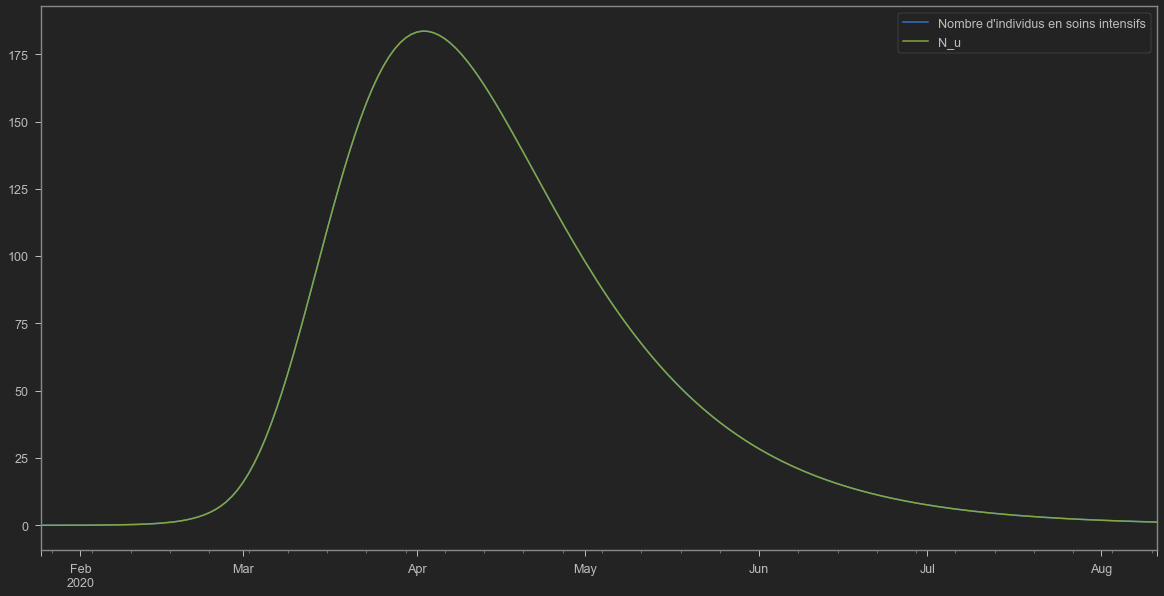

In [6]:
chose_sim =999 #for plots
start_date = t0[chose_sim]
range_date = pd.date_range(start = start_date,periods=M,freq="D")
df_u = pd.DataFrame(data = U[chose_sim],index = range_date,columns=["Nombre d'individus en soins intensifs"])
df_u["N_u"]=df_u["Nombre d'individus en soins intensifs"] #shorter name
fig = df_u.plot(figsize=[20,10])
max_u = np.int(df_u["N_u"].max())
date_max_u = df_u["N_u"].idxmax()
N_jours= np.int((date_max_u-df_u.index[0])/np.timedelta64(1,'D'))
print("le début de l'épidémie a lieu le",df_u.index[0].date())
print("Le nombre maximal de patients présents en soins intensif est ", max_u," personnes et ce maximum est atteint le", date_max_u.date(), "soit", N_jours, "jours après le début")

Question 2

a/ Loi du Nombre maximal de patients présents en soins intensifs

In [7]:
Max=np.max(U,axis=1)
print('Moyenne du nombre maximal de patients présents en soins intensifs:',int(np.mean(Max)), 'personnes')

Moyenne du nombre maximal de patients présents en soins intensifs: 20014 personnes


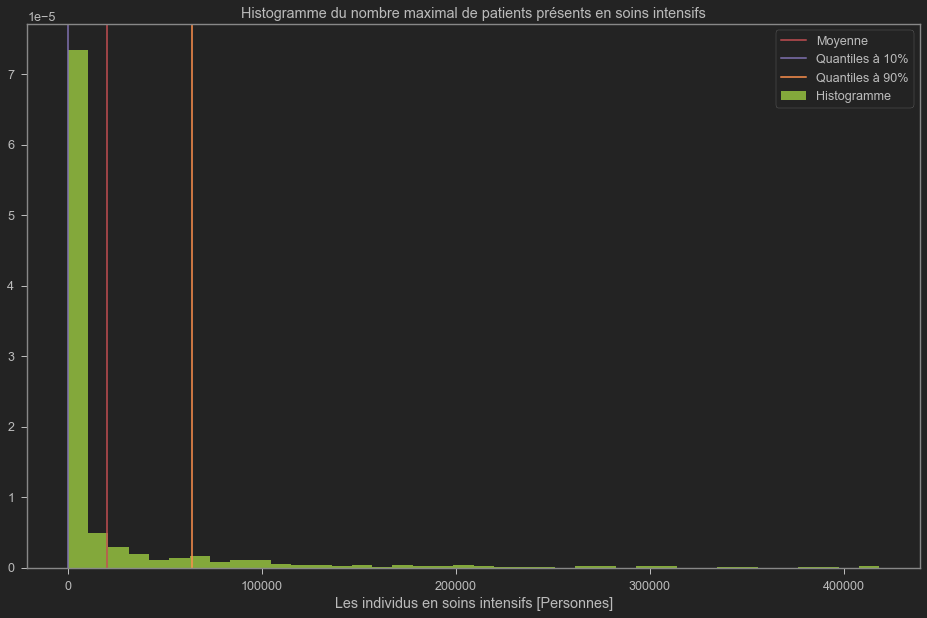

In [8]:
plt.figure(figsize=(16,10))
plt.hist(Max,bins=40,density=True,color='C1',label='Histogramme')
plt.xlabel("Les individus en soins intensifs [Personnes]")
plt.title('Histogramme du nombre maximal de patients présents en soins intensifs')
plt.axvline(np.mean(Max),color='C2',label='Moyenne')
plt.axvline(np.quantile(Max,0.1),color='C3',label='Quantiles à 10%')
plt.axvline(np.quantile(Max,0.9),color='C4',label='Quantiles à 90%')
plt.legend()
plt.show()

b/loi de la date du pic de l'épidémie

In [24]:
days_max = np.argmax(U,axis=1)

In [36]:
df_date = pd.DataFrame(data=t0,columns=["date_start"])

In [46]:
df_date["date_max"] = df_date["date_start"]
for i in range(len(df_date)):
    df_date["date_max"][i]+=np.timedelta64(days_max[i],'D')

In [62]:
max_date_mean = df_date["date_max"].mean()
print("le pic de l'épidémie a lieu en moyenne le",max_date_mean.date())

le pic de l'épidémie a lieu en moyenne le 2020-04-22


le pic de l'épidémie a lieu en moyenne le 2020-04-22


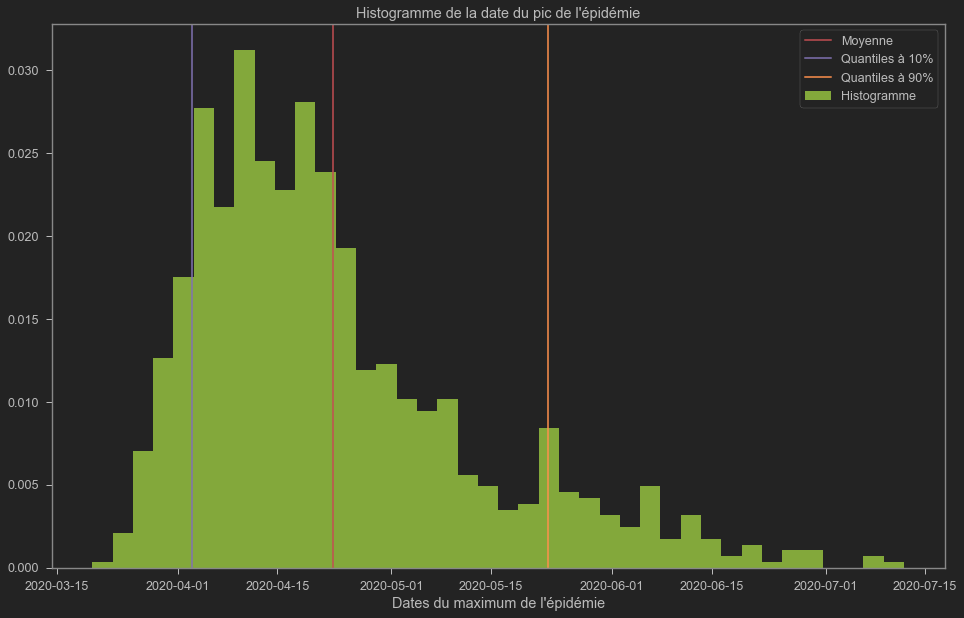

In [74]:
max_date_mean = df_date["date_max"].mean()
print("le pic de l'épidémie a lieu en moyenne le",max_date_mean.date())
q_90 = pd.to_datetime(df_date["date_max"].quantile(.9, interpolation='nearest'))
q_10 = pd.to_datetime(df_date["date_max"].quantile(.1, interpolation='nearest'))
plt.figure(figsize=(16,10))
plt.hist(df_date["date_max"],bins=40,density=True,color='C1',label='Histogramme')
plt.xlabel("Dates du maximum de l'épidémie")
plt.title("Histogramme de la date du pic de l'épidémie")
plt.axvline(max_date_mean,color='C2',label='Moyenne')
plt.axvline(q_10,color='C3',label='Quantiles à 10%')
plt.axvline(q_90,color='C4',label='Quantiles à 90%')
plt.legend()
plt.show()

**4 Analyse de sensibilité**

4.1 Analyse de sensibilité qualitative : Criblage

Question 3: